<a href="https://colab.research.google.com/github/SeojinSeojin/deep-learning_challenge/blob/main/word2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 사용되는 모듈 import, 드라이브 설정

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import collections
import time
import sys, os
sys.path.append('..')
from google.colab import drive
drive.mount('/content/drive')
try:
    import urllib.request
except ImportError:
    raise ImportError('Use Python3!')
import pickle

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## one-hot을 사용한 CBOW 모델의 한계를 극복하는 Embedding Layer

In [2]:
class Embedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.idx = None

    def forward(self, idx):
        W, = self.params
        self.idx = idx
        out = W[idx]
        return out

    def backward(self, dout):
        dW, = self.grads
        dW[...] = 0
        np.add.at(dW, self.idx, dout)
        return None

class SigmoidWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.loss = None
        self.y = None 
        self.t = None 

    def forward(self, x, t):
        self.t = t
        self.y = 1 / (1 + np.exp(-x))

        self.loss = cross_entropy_error(np.c_[1 - self.y, self.y], self.t)

        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]

        dx = (self.y - self.t) * dout / batch_size
        return dx

def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 정답 데이터가 원핫 벡터일 경우 정답 레이블 인덱스로 변환
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]

    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

In [3]:
class EmbeddingDot:
    def __init__(self, W):
        self.embed = Embedding(W)
        self.params = self.embed.params
        self.grads = self.embed.grads
        self.cache = None

    def forward(self, h, idx):
        target_W = self.embed.forward(idx)
        out = np.sum(target_W * h, axis=1)

        self.cache = (h, target_W)
        return out

    def backward(self, dout):
        h, target_W = self.cache
        dout = dout.reshape(dout.shape[0], 1)

        dtarget_W = dout * h
        self.embed.backward(dtarget_W)
        dh = dout * target_W
        return dh


class UnigramSampler:
    def __init__(self, corpus, power, sample_size):
        self.sample_size = sample_size
        self.vocab_size = None
        self.word_p = None

        counts = collections.Counter()
        for word_id in corpus:
            counts[word_id] += 1

        vocab_size = len(counts)
        self.vocab_size = vocab_size

        self.word_p = np.zeros(vocab_size)
        for i in range(vocab_size):
            self.word_p[i] = counts[i]

        self.word_p = np.power(self.word_p, power)
        self.word_p /= np.sum(self.word_p)

    def get_negative_sample(self, target):
        batch_size = target.shape[0]
        negative_sample = np.zeros((batch_size, self.sample_size), dtype=np.int32)

        for i in range(batch_size):
            p = self.word_p.copy()
            target_idx = target[i]
            p[target_idx] = 0
            p /= p.sum()
            negative_sample[i, :] = np.random.choice(self.vocab_size, size=self.sample_size, replace=False, p=p)

        return negative_sample


class NegativeSamplingLoss:
    def __init__(self, W, corpus, power=0.75, sample_size=5):
        self.sample_size = sample_size
        self.sampler = UnigramSampler(corpus, power, sample_size)
        self.loss_layers = [SigmoidWithLoss() for _ in range(sample_size + 1)]
        self.embed_dot_layers = [EmbeddingDot(W) for _ in range(sample_size + 1)]

        self.params, self.grads = [], []
        for layer in self.embed_dot_layers:
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, h, target):
        batch_size = target.shape[0]
        negative_sample = self.sampler.get_negative_sample(target)

        score = self.embed_dot_layers[0].forward(h, target)
        correct_label = np.ones(batch_size, dtype=np.int32)
        loss = self.loss_layers[0].forward(score, correct_label)

        negative_label = np.zeros(batch_size, dtype=np.int32)
        for i in range(self.sample_size):
            negative_target = negative_sample[:, i]
            score = self.embed_dot_layers[1 + i].forward(h, negative_target)
            loss += self.loss_layers[1 + i].forward(score, negative_label)

        return loss

    def backward(self, dout=1):
        dh = 0
        for l0, l1 in zip(self.loss_layers, self.embed_dot_layers):
            dscore = l0.backward(dout)
            dh += l1.backward(dscore)

        return dh


class SkipGram:
    def __init__(self, vocab_size, hidden_size, window_size, corpus):
        V, H = vocab_size, hidden_size
        rn = np.random.randn

        W_in = 0.01 * rn(V, H).astype('f')
        W_out = 0.01 * rn(V, H).astype('f')

        self.in_layer = Embedding(W_in)
        self.loss_layers = []
        for i in range(2 * window_size):
            layer = NegativeSamplingLoss(W_out, corpus, power=0.75, sample_size=5)
            self.loss_layers.append(layer)

        layers = [self.in_layer] + self.loss_layers
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        self.word_vecs = W_in

    def forward(self, contexts, target):
        h = self.in_layer.forward(target)

        loss = 0
        for i, layer in enumerate(self.loss_layers):
            loss += layer.forward(h, contexts[:, i])
        return loss

    def backward(self, dout=1):
        dh = 0
        for i, layer in enumerate(self.loss_layers):
            dh += layer.backward(dout)
        self.in_layer.backward(dh)
        return None

## 개선된 CBOW 모델

In [4]:
class CBOW:
    def __init__(self, vocab_size, hidden_size, window_size, corpus):
        V, H = vocab_size, hidden_size

        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(V, H).astype('f')

        self.in_layers = []
        for i in range(2 * window_size):
            layer = Embedding(W_in)
            self.in_layers.append(layer)
        self.ns_loss = NegativeSamplingLoss(W_out, corpus, power=0.75, sample_size=5)

        layers = self.in_layers + [self.ns_loss]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        self.word_vecs = W_in

    def forward(self, contexts, target):
        h = 0
        for i, layer in enumerate(self.in_layers):
            h += layer.forward(contexts[:, i])
        h *= 1 / len(self.in_layers)
        loss = self.ns_loss.forward(h, target)
        return loss

    def backward(self, dout=1):
        dout = self.ns_loss.backward(dout)
        dout *= 1 / len(self.in_layers)
        for layer in self.in_layers:
            layer.backward(dout)
        return None

## 학습 시켜주는 클래스

In [5]:
import numpy

class Trainer:
    def __init__(self, model, optimizer):
        self.model = model
        self.optimizer = optimizer
        self.loss_list = []
        self.eval_interval = None
        self.current_epoch = 0

    def fit(self, x, t, max_epoch=10, batch_size=32, max_grad=None, eval_interval=20):
        data_size = len(x)
        max_iters = data_size // batch_size
        self.eval_interval = eval_interval
        model, optimizer = self.model, self.optimizer
        total_loss = 0
        loss_count = 0

        start_time = time.time()
        for epoch in range(max_epoch):
            idx = numpy.random.permutation(numpy.arange(data_size))
            x = x[idx]
            t = t[idx]

            for iters in range(max_iters):
                batch_x = x[iters*batch_size:(iters+1)*batch_size]
                batch_t = t[iters*batch_size:(iters+1)*batch_size]

                loss = model.forward(batch_x, batch_t)
                model.backward()
                params, grads = remove_duplicate(model.params, model.grads)
                if max_grad is not None:
                    clip_grads(grads, max_grad)
                optimizer.update(params, grads)
                total_loss += loss
                loss_count += 1

                if (eval_interval is not None) and (iters % eval_interval) == 0:
                    avg_loss = total_loss / loss_count
                    elapsed_time = time.time() - start_time
                    print('| 에폭 %d |  반복 %d / %d | 시간 %d[s] | 손실 %.2f'
                          % (self.current_epoch + 1, iters + 1, max_iters, elapsed_time, avg_loss))
                    self.loss_list.append(float(avg_loss))
                    total_loss, loss_count = 0, 0

            self.current_epoch += 1

    def plot(self, ylim=None):
        x = numpy.arange(len(self.loss_list))
        if ylim is not None:
            plt.ylim(*ylim)
        plt.plot(x, self.loss_list, label='train')
        plt.xlabel('반복 (x' + str(self.eval_interval) + ')')
        plt.ylabel('손실')
        plt.show()

def remove_duplicate(params, grads):
    params, grads = params[:], grads[:] 

    while True:
        find_flg = False
        L = len(params)

        for i in range(0, L - 1):
            for j in range(i + 1, L):
                if params[i] is params[j]:
                    grads[i] += grads[j]  
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)
                elif params[i].ndim == 2 and params[j].ndim == 2 and \
                     params[i].T.shape == params[j].shape and np.all(params[i].T == params[j]):
                    grads[i] += grads[j].T
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)

                if find_flg: break
            if find_flg: break

        if not find_flg: break

    return params, grads

## Nesterov Optimizer

In [6]:
class Nesterov:

    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = []
            for param in params:
                self.v.append(np.zeros_like(param))

        for i in range(len(params)):
            self.v[i] *= self.momentum
            self.v[i] -= self.lr * grads[i]
            params[i] += self.momentum * self.momentum * self.v[i]
            params[i] -= (1 + self.momentum) * self.lr * grads[i]

## PTB 데이터셋 다운받기

In [7]:
url_base = 'https://raw.githubusercontent.com/tomsercu/lstm/master/data/'
key_file = {
    'train':'ptb.train.txt',
    'test':'ptb.test.txt',
    'valid':'ptb.valid.txt'
}
save_file = {
    'train':'ptb.train.npy',
    'test':'ptb.test.npy',
    'valid':'ptb.valid.npy'
}
vocab_file = 'ptb.vocab.pkl'

dataset_dir = os.path.dirname(os.path.abspath(''))


def _download(file_name):
    file_path = dataset_dir + '/' + file_name
    if os.path.exists(file_path):
        return

    print('Downloading ' + file_name + ' ... ')

    try:
        urllib.request.urlretrieve(url_base + file_name, file_path)
    except urllib.error.URLError:
        import ssl
        ssl._create_default_https_context = ssl._create_unverified_context
        urllib.request.urlretrieve(url_base + file_name, file_path)

    print('Done')


def load_vocab():
    vocab_path = dataset_dir + '/' + vocab_file

    if os.path.exists(vocab_path):
        with open(vocab_path, 'rb') as f:
            word_to_id, id_to_word = pickle.load(f)
        return word_to_id, id_to_word

    word_to_id = {}
    id_to_word = {}
    data_type = 'train'
    file_name = key_file[data_type]
    file_path = dataset_dir + '/' + file_name

    _download(file_name)

    words = open(file_path).read().replace('\n', '<eos>').strip().split()

    for i, word in enumerate(words):
        if word not in word_to_id:
            tmp_id = len(word_to_id)
            word_to_id[word] = tmp_id
            id_to_word[tmp_id] = word

    with open(vocab_path, 'wb') as f:
        pickle.dump((word_to_id, id_to_word), f)

    return word_to_id, id_to_word


def load_data(data_type='train'):
    '''
        :param data_type: 데이터 유형: 'train' or 'test' or 'valid (val)'
        :return:
    '''
    if data_type == 'val': data_type = 'valid'
    save_path = dataset_dir + '/' + save_file[data_type]

    word_to_id, id_to_word = load_vocab()

    if os.path.exists(save_path):
        corpus = np.load(save_path)
        return corpus, word_to_id, id_to_word

    file_name = key_file[data_type]
    file_path = dataset_dir + '/' + file_name
    _download(file_name)

    words = open(file_path).read().replace('\n', '<eos>').strip().split()
    corpus = np.array([word_to_id[w] for w in words])

    np.save(save_path, corpus)
    return corpus, word_to_id, id_to_word

def create_contexts_target(corpus, window_size=1):
    target = corpus[window_size:-window_size]
    contexts = []

    for idx in range(window_size, len(corpus)-window_size):
        cs = []
        for t in range(-window_size, window_size + 1):
            if t == 0:
                continue
            cs.append(corpus[idx + t])
        contexts.append(cs)

    return np.array(contexts), np.array(target)

In [8]:
window_size = 5
hidden_size = 100
batch_size = 100
max_epoch = 3

corpus, word_to_id, id_to_word = load_data('train')
vocab_size = len(word_to_id)

contexts, target = create_contexts_target(corpus, window_size)


Done


## 모델 생성 및 학습

| 에폭 1 |  반복 1 / 9295 | 시간 0[s] | 손실 4.16
| 에폭 1 |  반복 21 / 9295 | 시간 1[s] | 손실 4.16
| 에폭 1 |  반복 41 / 9295 | 시간 2[s] | 손실 4.16
| 에폭 1 |  반복 61 / 9295 | 시간 3[s] | 손실 4.16
| 에폭 1 |  반복 81 / 9295 | 시간 5[s] | 손실 4.16
| 에폭 1 |  반복 101 / 9295 | 시간 6[s] | 손실 4.16
| 에폭 1 |  반복 121 / 9295 | 시간 7[s] | 손실 4.16
| 에폭 1 |  반복 141 / 9295 | 시간 8[s] | 손실 4.16
| 에폭 1 |  반복 161 / 9295 | 시간 10[s] | 손실 4.16
| 에폭 1 |  반복 181 / 9295 | 시간 11[s] | 손실 4.16
| 에폭 1 |  반복 201 / 9295 | 시간 12[s] | 손실 4.16
| 에폭 1 |  반복 221 / 9295 | 시간 13[s] | 손실 4.16
| 에폭 1 |  반복 241 / 9295 | 시간 15[s] | 손실 4.16
| 에폭 1 |  반복 261 / 9295 | 시간 16[s] | 손실 4.16
| 에폭 1 |  반복 281 / 9295 | 시간 17[s] | 손실 4.16
| 에폭 1 |  반복 301 / 9295 | 시간 18[s] | 손실 4.16
| 에폭 1 |  반복 321 / 9295 | 시간 20[s] | 손실 4.16
| 에폭 1 |  반복 341 / 9295 | 시간 21[s] | 손실 4.16
| 에폭 1 |  반복 361 / 9295 | 시간 22[s] | 손실 4.16
| 에폭 1 |  반복 381 / 9295 | 시간 24[s] | 손실 4.16
| 에폭 1 |  반복 401 / 9295 | 시간 25[s] | 손실 4.16
| 에폭 1 |  반복 421 / 9295 | 시간 26[s] | 손실 4.16
| 에폭 1 |  반복 441 / 9295 

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48373 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49552 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49892 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 48373 missing from current font.
  font.set_te

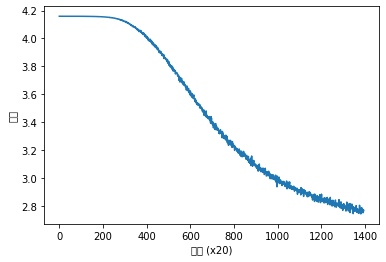

In [11]:
# 모델 생성
model = CBOW(vocab_size, hidden_size, window_size, corpus)
optimizer = Nesterov()
trainer = Trainer(model, optimizer)

# 학습 시작
trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

# 피클 파일 만들기
word_vecs = model.word_vecs
params = {}
params['word_vecs'] = word_vecs.astype(np.float16)
params['word_to_id'] = word_to_id
params['id_to_word'] = id_to_word
pkl_file = 'cbow_params.pkl'  # or 'skipgram_params.pkl'
with open(pkl_file, 'wb') as f:
    pickle.dump(params, f, -1)

## 코사인 유사도로 순위 먹이는 함수

In [14]:
def cos_similarity(x, y, eps=1e-8):
    nx = x / (np.sqrt(np.sum(x ** 2)) + eps)
    ny = y / (np.sqrt(np.sum(y ** 2)) + eps)
    return np.dot(nx, ny)


def most_similar(query, word_to_id, id_to_word, word_matrix, top=5):
    if query not in word_to_id:
        print('%s(을)를 찾을 수 없습니다.' % query)
        return

    print('\n[query] ' + query)
    query_id = word_to_id[query]
    query_vec = word_matrix[query_id]

    vocab_size = len(id_to_word)

    similarity = np.zeros(vocab_size)
    for i in range(vocab_size):
        similarity[i] = cos_similarity(word_matrix[i], query_vec)

    count = 0
    for i in (-1 * similarity).argsort():
        if id_to_word[i] == query:
            continue
        print(' %s: %s' % (id_to_word[i], similarity[i]))

        count += 1
        if count >= top:
            return


def analogy(a, b, c, word_to_id, id_to_word, word_matrix, top=5, answer=None):
    for word in (a, b, c):
        if word not in word_to_id:
            print('%s(을)를 찾을 수 없습니다.' % word)
            return

    print('\n[analogy] ' + a + ':' + b + ' = ' + c + ':?')
    a_vec, b_vec, c_vec = word_matrix[word_to_id[a]], word_matrix[word_to_id[b]], word_matrix[word_to_id[c]]
    query_vec = b_vec - a_vec + c_vec
    query_vec = normalize(query_vec)

    similarity = np.dot(word_matrix, query_vec)

    if answer is not None:
        print("==>" + answer + ":" + str(np.dot(word_matrix[word_to_id[answer]], query_vec)))

    count = 0
    for i in (-1 * similarity).argsort():
        if np.isnan(similarity[i]):
            continue
        if id_to_word[i] in (a, b, c):
            continue
        print(' {0}: {1}'.format(id_to_word[i], similarity[i]))

        count += 1
        if count >= top:
            return

def normalize(x):
    if x.ndim == 2:
        s = np.sqrt((x * x).sum(1))
        x /= s.reshape((s.shape[0], 1))
    elif x.ndim == 1:
        s = np.sqrt((x * x).sum())
        x /= s
    return x

## 모델 평가

In [18]:
word_vecs = params['word_vecs']
word_to_id = params['word_to_id']
id_to_word = params['id_to_word']

print("most similar word")
querys = ["brother", "school", "computer"]
for query in querys:
  most_similar(query, word_to_id, id_to_word, word_vecs, top=5)

print()
print("analogy word")
analogy("parent", "adult", "child", word_to_id, id_to_word, word_vecs)

most similar word

[query] brother
 buy-back: 0.34326171875
 birds: 0.33642578125
 l.: 0.33447265625
 sun: 0.333984375
 candidates: 0.333740234375

[query] school
 those: 0.673828125
 who: 0.671875
 capital: 0.67138671875
 since: 0.669921875
 through: 0.66943359375

[query] computer
 by: 0.927734375
 and: 0.9267578125
 an: 0.9267578125
 on: 0.92578125
 of: 0.92529296875

analogy word

[analogy] parent:adult = child:?
 busiest: 0.03924560546875
 wedtech: 0.0301666259765625
 penn: 0.028778076171875
 frenzy: 0.0281829833984375
 tightening: 0.02789306640625
